🔍 DEBUG: Parámetros optimizados sugeridos:
  🎯 Feature complexity: 0.508
  🎯 CatBoost complexity: 0.991
  📊 Periods strategy: geometric
  📊 Stats strategy: distribution_focused
  atr_period: 28
  cat_main_depth: 5
  cat_main_early_stopping: 145
  cat_main_iterations: 418
  cat_main_l2_leaf_reg: 1.5978969420743183
  cat_main_learning_rate: 0.14536248839265492
  cat_meta_depth: 7
  cat_meta_early_stopping: 168
  cat_meta_iterations: 485
  cat_meta_l2_leaf_reg: 2.0577022653881007
  cat_meta_learning_rate: 0.16527320416742675
  covariance_type: diag
  markup: 0.4385583146173149
  max_iter: 180
  max_main_periods: 4
  max_main_stats: 2
  max_meta_periods: 3
  max_meta_stats: 3
  max_val: 5
  method: min
  min_val: 2
  n_components: 10
  periods_main: (10, 17, 30, 52)
  periods_meta: (4, 5, 6)
  stats_main: ('zscore', 'corrskew')
  stats_meta: ('cv', 'iqr')
🔍 DEBUG: base_df.shape = (42333, 5)
🔍 DEBUG: train_start = 2019-01-01 00:00:00, train_end = 2025-01-01 00:00:00
🔍 DEBUG: test_start = 20

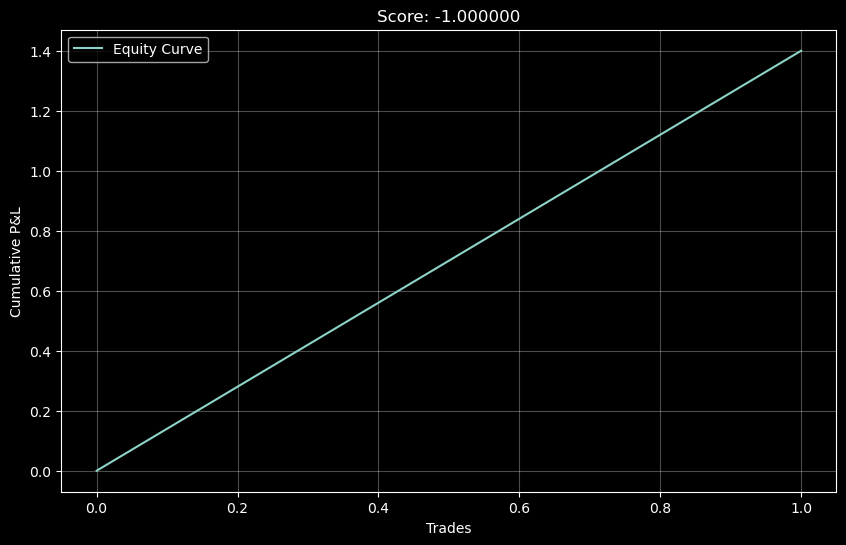

🔍 DEBUG: Strategy Metrics - Score: -1.000000
  📈 LINEALITY METRICS:
    • R²=0.000000 | Perfect Linearity=0.000000
    • Linearity Bonus=0.000000
  📊 GROWTH METRICS:
    • Consistency=0.000000 | Slope Reward=0.000000
    • Monotonic Growth=0.000000
  🎯 QUALITY METRICS:
    • Smoothness=0.000000 | Total Return=0.000000
    • DD Penalty=0.000000
  🔧 COMPONENT SCORES:
    • Linearity Comp=0.000000 | Growth Comp=0.000000
    • Quality Comp=0.000000
  🏆 FINAL SCORES:
    • Base=0.000000 | Penalized=0.000000

🔍 DEBUG: Tiempo de test in-sample: 5.74 segundos
🔍 DEBUG: Score in-sample: -1.0
🔍 DEBUG: Modelos guardados en /tmp/tmpbiyg45pl.onnx y /tmp/tmp4i0w0lje.onnx
🔍 DEBUG: Main model data shape: (8050, 9)
🔍 DEBUG: Main feature columns: ['10_zscore_feature', '10_corrskew_feature', '17_zscore_feature', '17_corrskew_feature', '30_zscore_feature', '30_corrskew_feature', '52_zscore_feature', '52_corrskew_feature']
🔍 DEBUG: train_mask.sum() después de evitar solapamiento = 5992
🔍 DEBUG: train_data.s

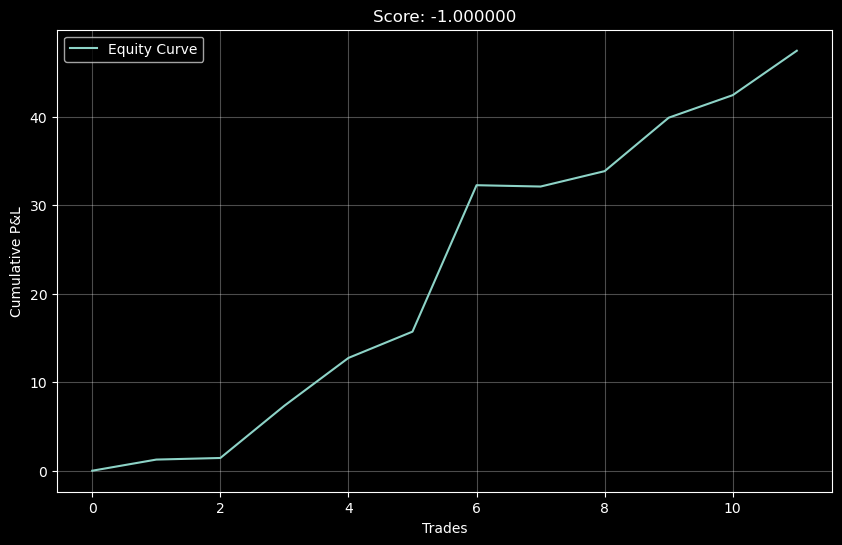

🔍 DEBUG: Strategy Metrics - Score: -1.000000
  📈 LINEALITY METRICS:
    • R²=0.000000 | Perfect Linearity=0.000000
    • Linearity Bonus=0.000000
  📊 GROWTH METRICS:
    • Consistency=0.000000 | Slope Reward=0.000000
    • Monotonic Growth=0.000000
  🎯 QUALITY METRICS:
    • Smoothness=0.000000 | Total Return=0.000000
    • DD Penalty=0.000000
  🔧 COMPONENT SCORES:
    • Linearity Comp=0.000000 | Growth Comp=0.000000
    • Quality Comp=0.000000
  🏆 FINAL SCORES:
    • Base=0.000000 | Penalized=0.000000

🔍 DEBUG: Tiempo de test in-sample: 0.09 segundos
🔍 DEBUG: Score in-sample: -1.0
🔍 DEBUG: Modelos guardados en /tmp/tmpb7v3fqr0.onnx y /tmp/tmpklpvgsey.onnx
🔍 DEBUG: Main model data shape: (1260, 9)
🔍 DEBUG: Main feature columns: ['10_zscore_feature', '10_corrskew_feature', '17_zscore_feature', '17_corrskew_feature', '30_zscore_feature', '30_corrskew_feature', '52_zscore_feature', '52_corrskew_feature']
🔍 DEBUG: train_mask.sum() después de evitar solapamiento = 952
🔍 DEBUG: train_data.sh

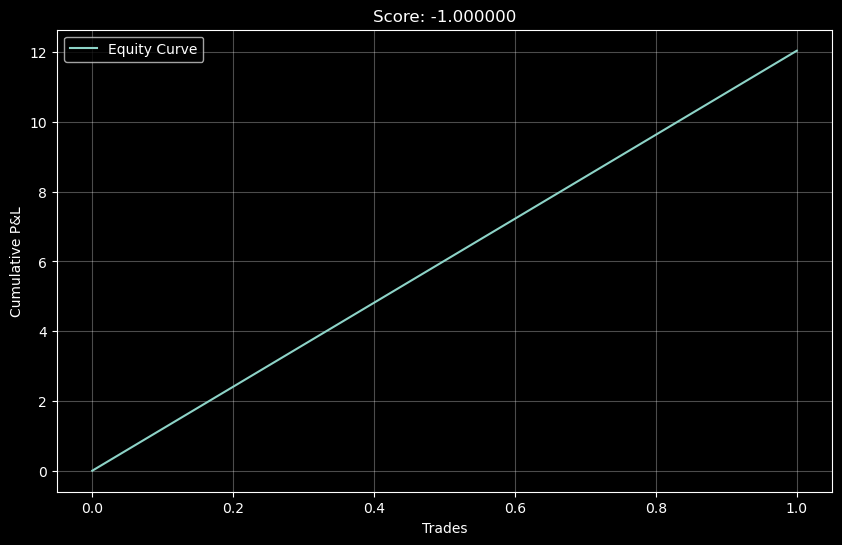

🔍 DEBUG: Strategy Metrics - Score: -1.000000
  📈 LINEALITY METRICS:
    • R²=0.000000 | Perfect Linearity=0.000000
    • Linearity Bonus=0.000000
  📊 GROWTH METRICS:
    • Consistency=0.000000 | Slope Reward=0.000000
    • Monotonic Growth=0.000000
  🎯 QUALITY METRICS:
    • Smoothness=0.000000 | Total Return=0.000000
    • DD Penalty=0.000000
  🔧 COMPONENT SCORES:
    • Linearity Comp=0.000000 | Growth Comp=0.000000
    • Quality Comp=0.000000
  🏆 FINAL SCORES:
    • Base=0.000000 | Penalized=0.000000

🔍 DEBUG: Tiempo de test in-sample: 0.09 segundos
🔍 DEBUG: Score in-sample: -1.0
🔍 DEBUG: Modelos guardados en /tmp/tmpeawnq32w.onnx y /tmp/tmp23heeh4p.onnx
🔍 DEBUG: Main model data shape: (525, 9)
🔍 DEBUG: Main feature columns: ['10_zscore_feature', '10_corrskew_feature', '17_zscore_feature', '17_corrskew_feature', '30_zscore_feature', '30_corrskew_feature', '52_zscore_feature', '52_corrskew_feature']
🔍 DEBUG: train_mask.sum() después de evitar solapamiento = 408
🔍 DEBUG: train_data.sha

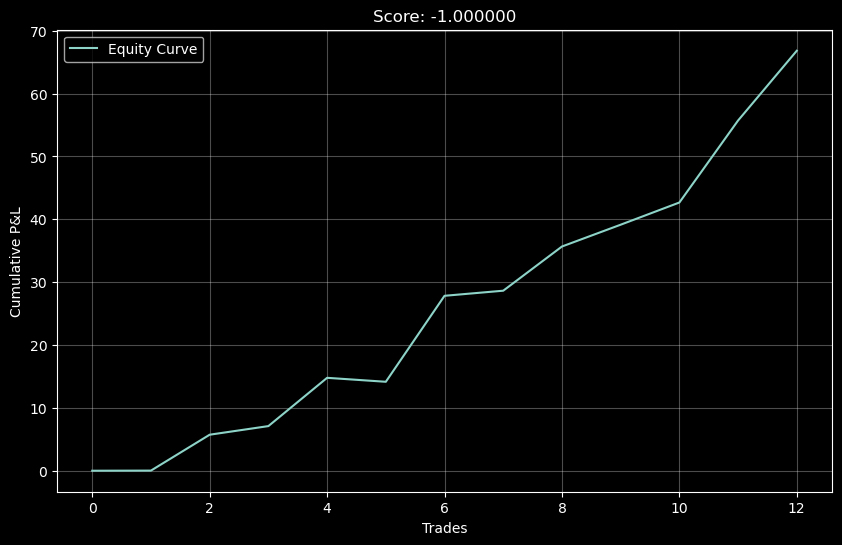

🔍 DEBUG: Strategy Metrics - Score: -1.000000
  📈 LINEALITY METRICS:
    • R²=0.000000 | Perfect Linearity=0.000000
    • Linearity Bonus=0.000000
  📊 GROWTH METRICS:
    • Consistency=0.000000 | Slope Reward=0.000000
    • Monotonic Growth=0.000000
  🎯 QUALITY METRICS:
    • Smoothness=0.000000 | Total Return=0.000000
    • DD Penalty=0.000000
  🔧 COMPONENT SCORES:
    • Linearity Comp=0.000000 | Growth Comp=0.000000
    • Quality Comp=0.000000
  🏆 FINAL SCORES:
    • Base=0.000000 | Penalized=0.000000

🔍 DEBUG: Tiempo de test in-sample: 0.11 segundos
🔍 DEBUG: Score in-sample: -1.0
🔍 DEBUG: Modelos guardados en /tmp/tmpd0lqka5z.onnx y /tmp/tmpeqd5qum6.onnx
🔍 DEBUG: Main model data shape: (205, 9)
🔍 DEBUG: Main feature columns: ['10_zscore_feature', '10_corrskew_feature', '17_zscore_feature', '17_corrskew_feature', '30_zscore_feature', '30_corrskew_feature', '52_zscore_feature', '52_corrskew_feature']
🔍 DEBUG: train_mask.sum() después de evitar solapamiento = 146
🔍 DEBUG: train_data.sha

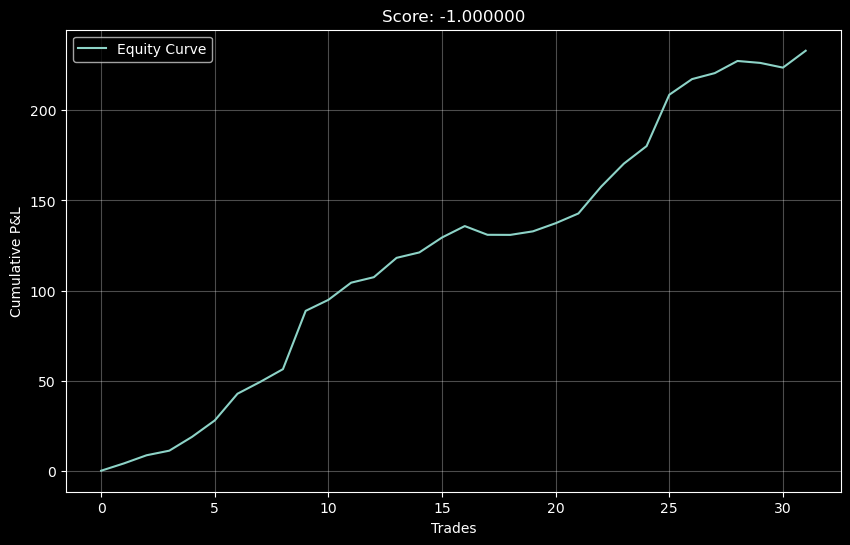

🔍 DEBUG: Strategy Metrics - Score: -1.000000
  📈 LINEALITY METRICS:
    • R²=0.000000 | Perfect Linearity=0.000000
    • Linearity Bonus=0.000000
  📊 GROWTH METRICS:
    • Consistency=0.000000 | Slope Reward=0.000000
    • Monotonic Growth=0.000000
  🎯 QUALITY METRICS:
    • Smoothness=0.000000 | Total Return=0.000000
    • DD Penalty=0.000000
  🔧 COMPONENT SCORES:
    • Linearity Comp=0.000000 | Growth Comp=0.000000
    • Quality Comp=0.000000
  🏆 FINAL SCORES:
    • Base=0.000000 | Penalized=0.000000

🔍 DEBUG: Tiempo de test in-sample: 0.09 segundos
🔍 DEBUG: Score in-sample: -1.0
🔍 DEBUG: Modelos guardados en /tmp/tmp_jyehyu_.onnx y /tmp/tmp9ri_qf00.onnx
🔍 DEBUG: Main model data shape: (50, 9)
🔍 DEBUG: Main feature columns: ['10_zscore_feature', '10_corrskew_feature', '17_zscore_feature', '17_corrskew_feature', '30_zscore_feature', '30_corrskew_feature', '52_zscore_feature', '52_corrskew_feature']
🔍 DEBUG: train_mask.sum() después de evitar solapamiento = 45
🔍 DEBUG: train_data.shape

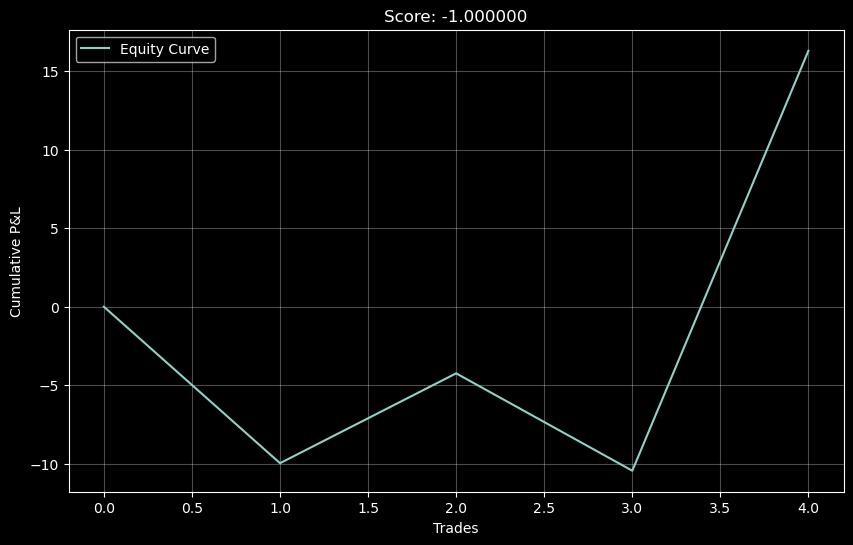

🔍 DEBUG: Strategy Metrics - Score: -1.000000
  📈 LINEALITY METRICS:
    • R²=0.000000 | Perfect Linearity=0.000000
    • Linearity Bonus=0.000000
  📊 GROWTH METRICS:
    • Consistency=0.000000 | Slope Reward=0.000000
    • Monotonic Growth=0.000000
  🎯 QUALITY METRICS:
    • Smoothness=0.000000 | Total Return=0.000000
    • DD Penalty=0.000000
  🔧 COMPONENT SCORES:
    • Linearity Comp=0.000000 | Growth Comp=0.000000
    • Quality Comp=0.000000
  🏆 FINAL SCORES:
    • Base=0.000000 | Penalized=0.000000

🔍 DEBUG: Tiempo de test in-sample: 0.08 segundos
🔍 DEBUG: Score in-sample: -1.0
🔍 DEBUG: Modelos guardados en /tmp/tmpt0l6ce7g.onnx y /tmp/tmphscjyw_2.onnx
[XAUUSD_H1_buy_random_lgmm] modelo 0 trial 5/5004 score=0.000000 avg=5.36s mem=545.41MB 
🔍 DEBUG: Parámetros optimizados sugeridos:
  🎯 Feature complexity: 0.399
  🎯 CatBoost complexity: 0.402
  📊 Periods strategy: arithmetic
  📊 Stats strategy: volatility_focused
  atr_period: 11
  cat_main_depth: 5
  cat_main_early_stopping: 240
  

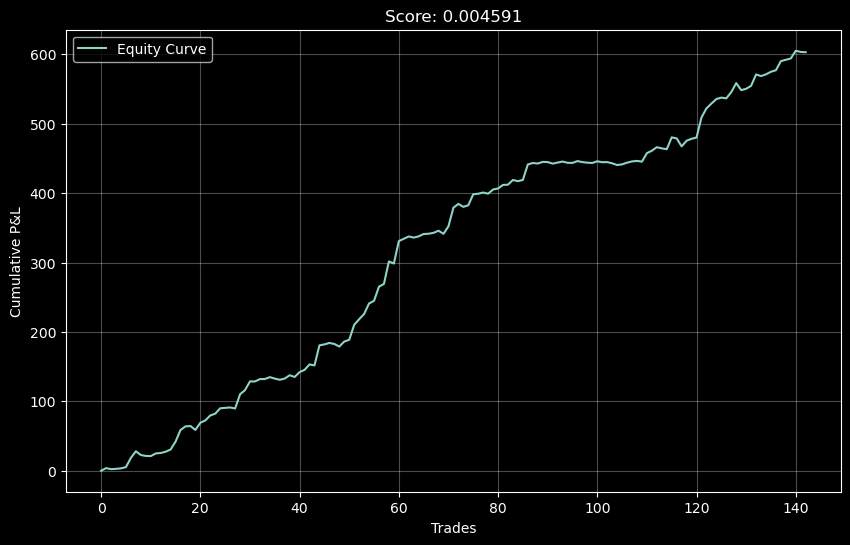

🔍 DEBUG: Strategy Metrics - Score: 0.004591
  📈 LINEALITY METRICS:
    • R²=1.000000 | Perfect Linearity=0.114662
    • Linearity Bonus=1.251268
  📊 GROWTH METRICS:
    • Consistency=0.123692 | Slope Reward=0.394778
    • Monotonic Growth=0.215844
  🎯 QUALITY METRICS:
    • Smoothness=0.172172 | Total Return=603.060000
    • DD Penalty=0.006677
  🔧 COMPONENT SCORES:
    • Linearity Comp=0.721245 | Growth Comp=0.259772
    • Quality Comp=0.503303
  🏆 FINAL SCORES:
    • Base=0.550112 | Penalized=0.003673

🔍 DEBUG: Tiempo de test in-sample: 0.11 segundos
🔍 DEBUG: Score in-sample: 0.004591124668059335
🔍 DEBUG: Modelos guardados en /tmp/tmpvldz0dat.onnx y /tmp/tmpp9s015dq.onnx
🔍 DEBUG: Main model data shape: (4567, 13)
🔍 DEBUG: Main feature columns: ['10_maxdd_feature', '10_var_feature', '35_maxdd_feature', '35_var_feature', '60_maxdd_feature', '60_var_feature', '85_maxdd_feature', '85_var_feature', '110_maxdd_feature', '110_var_feature', '135_maxdd_feature', '135_var_feature']
🔍 DEBUG: tr

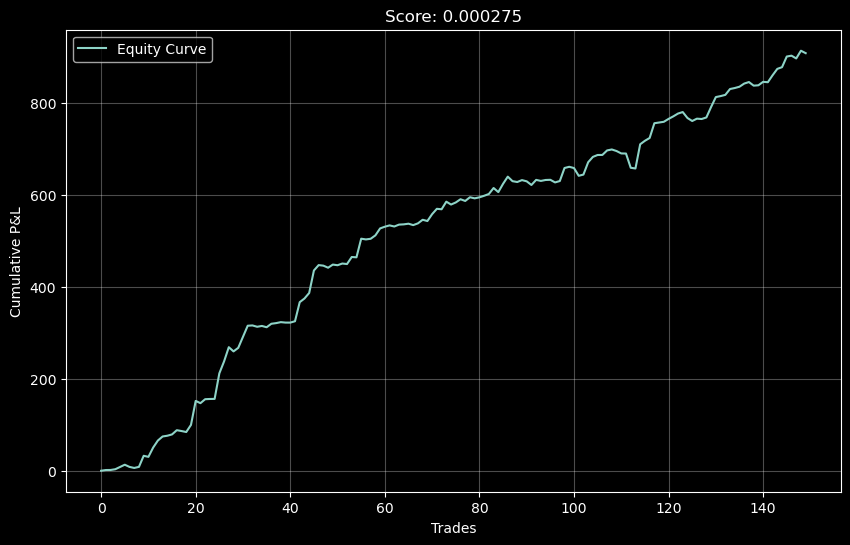

🔍 DEBUG: Strategy Metrics - Score: 0.000275
  📈 LINEALITY METRICS:
    • R²=1.000000 | Perfect Linearity=0.048106
    • Linearity Bonus=0.947535
  📊 GROWTH METRICS:
    • Consistency=0.105878 | Slope Reward=0.226777
    • Monotonic Growth=0.187786
  🎯 QUALITY METRICS:
    • Smoothness=0.239628 | Total Return=908.120000
    • DD Penalty=0.000470
  🔧 COMPONENT SCORES:
    • Linearity Comp=0.603503 | Growth Comp=0.178810
    • Quality Comp=0.543777
  🏆 FINAL SCORES:
    • Base=0.467136 | Penalized=0.000220

🔍 DEBUG: Tiempo de test in-sample: 0.13 segundos
🔍 DEBUG: Score in-sample: 0.00027455305187727274
🔍 DEBUG: Modelos guardados en /tmp/tmp9grm0n7_.onnx y /tmp/tmpypds734p.onnx
🔍 DEBUG: Main model data shape: (3730, 13)
🔍 DEBUG: Main feature columns: ['10_maxdd_feature', '10_var_feature', '35_maxdd_feature', '35_var_feature', '60_maxdd_feature', '60_var_feature', '85_maxdd_feature', '85_var_feature', '110_maxdd_feature', '110_var_feature', '135_maxdd_feature', '135_var_feature']
🔍 DEBUG: 

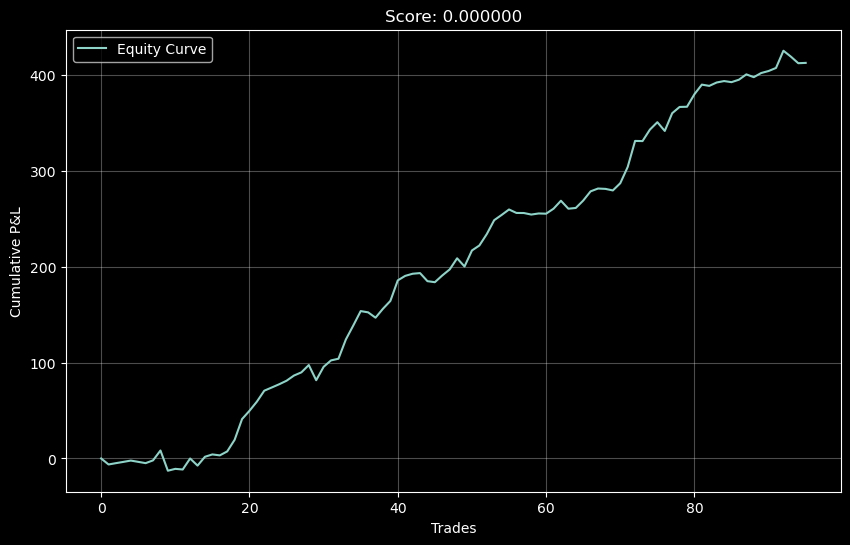

🔍 DEBUG: Strategy Metrics - Score: 0.000000
  📈 LINEALITY METRICS:
    • R²=1.000000 | Perfect Linearity=0.113119
    • Linearity Bonus=1.617205
  📊 GROWTH METRICS:
    • Consistency=0.120185 | Slope Reward=0.384050
    • Monotonic Growth=0.210435
  🎯 QUALITY METRICS:
    • Smoothness=0.180658 | Total Return=29.954942
    • DD Penalty=0.000001
  🔧 COMPONENT SCORES:
    • Linearity Comp=0.830409 | Growth Comp=0.252806
    • Quality Comp=0.508395
  🏆 FINAL SCORES:
    • Base=0.608826 | Penalized=0.000000

🔍 DEBUG: Tiempo de test in-sample: 0.13 segundos
🔍 DEBUG: Score in-sample: 4.092997480218165e-07
🔍 DEBUG: Modelos guardados en /tmp/tmpr5oeluxf.onnx y /tmp/tmpn543ys5r.onnx
[XAUUSD_H1_buy_random_lgmm] modelo 0 trial 6/5004 score=0.004591 avg=9.05s mem=564.75MB 
[XAUUSD_H1_buy_random_lgmm] terminado


In [ ]:
import optuna
from datetime import datetime
from concurrent.futures import ProcessPoolExecutor, as_completed
from modules.StrategySearcher import StrategySearcher
import warnings
import os
warnings.filterwarnings("ignore")

label_methods = [
    "random",
    "trend",
    "trend_profit",
    "trend_multi",
    "clusters",
    "multi_window",
    "validated_levels",
    "zigzag",
    "mean_rev",
    "mean_rev_multi",
    "mean_rev_vol",
    "filter",
    "multi_filter",
    "filter_bidirectional",
    "filter_one",
    "trend_one",
    "filter_flat",
]
search_methods = [
    'clusters',
    'markov',
    'lgmm',
    'wkmeans',
    'mapie',
    'causal',
]

configs = [
    dict(
        symbol='XAUUSD', timeframe='H1', direction='buy', pruner_type='sucessive',
        train_start=datetime(2019,1,1), train_end=datetime(2025,1,1),
        test_start=datetime(2022,1,1),  test_end=datetime(2023,6,1),
        label_method='random', search_type='lgmm', search_subtype='',
        n_models=1, debug=False,
    ),
]

# Actualizar n_jobs en cada configuración
for cfg in configs:
    cfg["tag"] = f"{cfg['symbol']}_{cfg['timeframe']}_{cfg['direction']}_{cfg['label_method']}_{cfg['search_type']}_{cfg.get('search_subtype', '')}".strip("_")

DB_FILE = f"optuna_dbs/{cfg['tag']}.db"
DB_PATH = f"sqlite:///{DB_FILE}"
STUDY_NAME = f"{cfg['tag']}"

study = None
if not os.path.exists(DB_FILE):
    study = None
else:
    try:
        study = optuna.load_study(study_name=STUDY_NAME, storage=DB_PATH)
    except Exception:
        study = None
if not study:
    n_trials = 5000
else:
    n_trials = len(study.trials) + 5000

for cfg in configs:
    cfg['n_trials'] = n_trials

def launch(cfg):
    s = StrategySearcher(**cfg)
    s.run_search()

with ProcessPoolExecutor(max_workers=len(configs)) as pool:
    futures = {pool.submit(launch, c): c["tag"] for c in configs}
    for f in as_completed(futures):
        tag = futures[f]
        try:
            print(f"[{tag}] terminado")
        except Exception as e:
            print(f"[{tag}] falló: {e}")